# DTW Evaluation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
import fastdtw
from scipy.spatial.distance import euclidean
from itertools import combinations
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

## DTW: The idea behind

In [3]:
def generate_uni_features_ts(lyrics):
    multi_ts = pd.DataFrame(lyrics_statistics(lyrics)).values
    ss = StandardScaler()
    multi_ts = ss.fit_transform(multi_ts)
    pca = PCA(n_components=1, random_state=0)
    uni_ts = np.array([pc[0] for pc in pca.fit_transform(multi_ts)])
    return uni_ts

In [4]:
eg_lyr = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
eg_similar_lyr = pd.read_csv('../data/toy-lyrics/toy_sim.csv', sep='\t')
eg_random_lyr = pd.read_csv('../data/toy-lyrics/toy_rnd.csv', sep='\t')

eg_lyrics = [eg_lyr, eg_similar_lyr, eg_random_lyr]

In [5]:
ts1, ts2, ts3 = [generate_uni_features_ts(list(lyr['lyrics'])) for lyr in eg_lyrics]

ts1_parts, ts2_parts, ts3_parts = [lyr['part'] for lyr in eg_lyrics]

color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(ts1_parts))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

In [6]:
sim_distance, warp_path = fastdtw.dtw(ts1, ts2)
print(f'DTW distance between similar lyrics: {sim_distance}')

rnd_distance = fastdtw.dtw(ts1, ts3)[0]
print(f'DTW distance between random lyrics: {rnd_distance}')

DTW distance between similar lyrics: 18.522647268377415
DTW distance between random lyrics: 37.319148778161114


In [7]:
ts2 = [10 + timestamp for timestamp in ts2] 

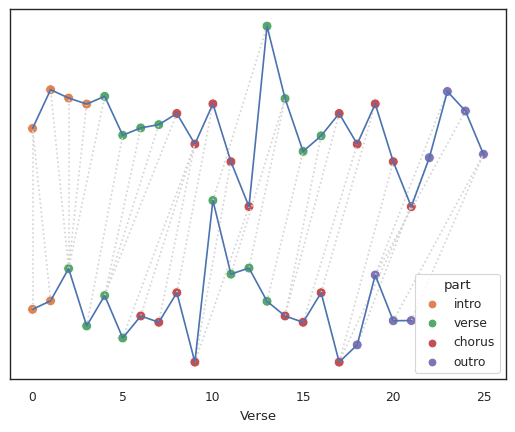

In [8]:
fig, ax = plt.subplots()

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [ts1[map_x], ts2[map_y]], linestyle='dotted', color='lightgray')

plt.plot(ts1, color=sns.color_palette()[0]) 
plt.plot(ts2, color=sns.color_palette()[0])

sns.scatterplot(y=ts1, x=range(len(ts1)),
                hue=ts1_parts, s=50, palette=color_map)

sns.scatterplot(y=ts2, x=range(len(ts2)),
                hue=ts2_parts, s=50, palette=color_map, legend=False)


ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Verse')
ax.tick_params(left=False)  # remove the ticks
tikzplotlib.save('../tikz/dtw_demo.tex')

In [9]:
def evaluate_ts_data(ts_type, normalize=True):    
    ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
    for column in ts_data.columns:
        ts_data[column] = list(
            map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
    if normalize:
        scaler = StandardScaler()            
        for column in ts_data.columns:
            ts_data[column] = list(
                map(lambda x: scaler.fit_transform(x.reshape(-1, 1)), ts_data[column]))    
    sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
    rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]
    sim_closer = sum(1 for similar, random in zip(sim_dtw, rnd_dtw) if similar < random)
    rnd_closer = sum(1 for similar, random in zip(sim_dtw, rnd_dtw) if random < similar)
    similarity_score = sim_closer / (sim_closer + rnd_closer)        
    avg_sim_dtw = np.mean(sim_dtw)
    std_sim_dtw = np.std(sim_dtw)
    avg_rnd_dtw = np.mean(rnd_dtw)
    std_rnd_dtw = np.std(rnd_dtw)
    
    metrics = {'type': ts_type,
               'similarity_score': round(similarity_score,2), 
               'sim_distance': {'avg': round(avg_sim_dtw,2), 'std': round(std_sim_dtw,2)},
               'rnd_distance': {'avg': round(avg_rnd_dtw,2), 'std': round(std_rnd_dtw,2)},}
    return metrics

In [10]:
def print_evaluation_metrics(evaluation_result):
    print(f'Type: {evaluation_result["type"]}')
    print(f'Similarity score: {evaluation_result["similarity_score"]}')
    print('Distances between similar pairs: '
        f'avg {evaluation_result["sim_distance"]["avg"]}, std {evaluation_result["sim_distance"]["std"]}')
    print('Distances between random pairs: '
        f'avg {evaluation_result["sim_distance"]["avg"]}, std {evaluation_result["sim_distance"]["std"]}')
    print()


# Features Time Series

In [11]:
ts_types = ['features_avg_ts', 'features_max_ts', 'features_pca_ts', 'features_gpca_ts']

for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    print_evaluation_metrics(evaluation_result)

Type: features_avg_ts
Similarity score: 0.87
Distances between similar pairs: avg 29.73, std 12.96
Distances between random pairs: avg 29.73, std 12.96



Type: features_max_ts
Similarity score: 0.63
Distances between similar pairs: avg 34.24, std 15.27
Distances between random pairs: avg 34.24, std 15.27



Type: features_pca_ts
Similarity score: 0.83
Distances between similar pairs: avg 25.59, std 14.32
Distances between random pairs: avg 25.59, std 14.32



Type: features_gpca_ts
Similarity score: 1.0
Distances between similar pairs: avg 13.53, std 6.96
Distances between random pairs: avg 13.53, std 6.96



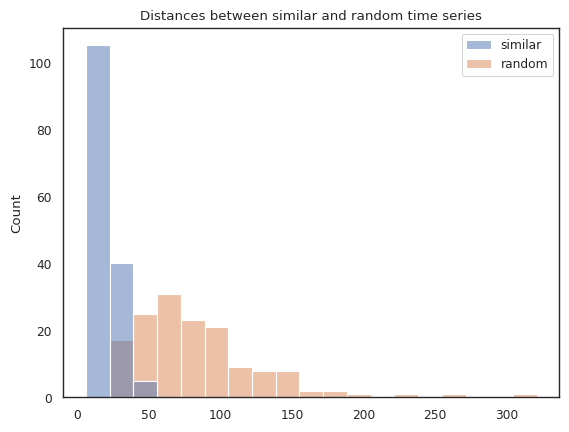

In [12]:
ts_type = 'features_gpca_ts'

ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
for column in ts_data.columns:
    ts_data[column] = list(
        map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]

x = sim_dtw+rnd_dtw
h = (['similar'] * len(sim_dtw)) + (['random'] * len(rnd_dtw))

fig, ax = plt.subplots()
ax = sns.histplot(x=x, hue=h)
ax.set_title('Distances between similar and random time series')

tikzplotlib.save('../tikz/hist_eval_features_gpca.tex')
    

## Sentence BERT Time Series

In [13]:
ts_types = ['sbert_avg_ts', 'sbert_max_ts', 'sbert_pca_ts', 'sbert_gpca_ts']

for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    print_evaluation_metrics(evaluation_result)

Type: sbert_avg_ts
Similarity score: 0.61
Distances between similar pairs: avg 36.04, std 16.6
Distances between random pairs: avg 36.04, std 16.6



Type: sbert_max_ts
Similarity score: 0.58
Distances between similar pairs: avg 35.92, std 16.24
Distances between random pairs: avg 35.92, std 16.24



Type: sbert_pca_ts
Similarity score: 0.62
Distances between similar pairs: avg 34.1, std 18.31
Distances between random pairs: avg 34.1, std 18.31



Type: sbert_gpca_ts
Similarity score: 0.76
Distances between similar pairs: avg 33.29, std 15.26
Distances between random pairs: avg 33.29, std 15.26



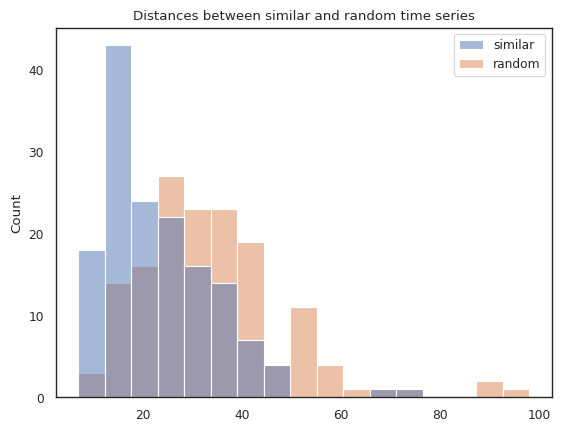

In [14]:
ts_type = 'sbert_gpca_ts'

ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
for column in ts_data.columns:
    ts_data[column] = list(
        map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]

x = sim_dtw+rnd_dtw
h = (['similar'] * len(sim_dtw)) + (['random'] * len(rnd_dtw))

fig, ax = plt.subplots()
ax = sns.histplot(x=x, hue=h)
ax.set_title('Distances between similar and random time series')

tikzplotlib.save('../tikz/hist_eval_sbert_gpca.tex')
    

## Doc2Vec Time Series

In [15]:
ts_types = ['d2v_avg_ts', 'd2v_max_ts', 'd2v_pca_ts', 'd2v_gpca_ts']

for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    print_evaluation_metrics(evaluation_result)

Type: d2v_avg_ts
Similarity score: 0.51
Distances between similar pairs: avg 37.8, std 17.23
Distances between random pairs: avg 37.8, std 17.23



Type: d2v_max_ts
Similarity score: 0.57
Distances between similar pairs: avg 35.69, std 15.85
Distances between random pairs: avg 35.69, std 15.85



Type: d2v_pca_ts
Similarity score: 0.46
Distances between similar pairs: avg 39.16, std 18.58
Distances between random pairs: avg 39.16, std 18.58



Type: d2v_gpca_ts
Similarity score: 0.5
Distances between similar pairs: avg 37.55, std 16.7
Distances between random pairs: avg 37.55, std 16.7



## Emotion Time Series

In [16]:
ts_types = ['emotion_ts', 'sentiment_ts']


for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    print_evaluation_metrics(evaluation_result)

Type: emotion_ts
Similarity score: 0.72
Distances between similar pairs: avg 34.65, std 15.94
Distances between random pairs: avg 34.65, std 15.94



Type: sentiment_ts
Similarity score: 0.77
Distances between similar pairs: avg 29.51, std 13.36
Distances between random pairs: avg 29.51, std 13.36



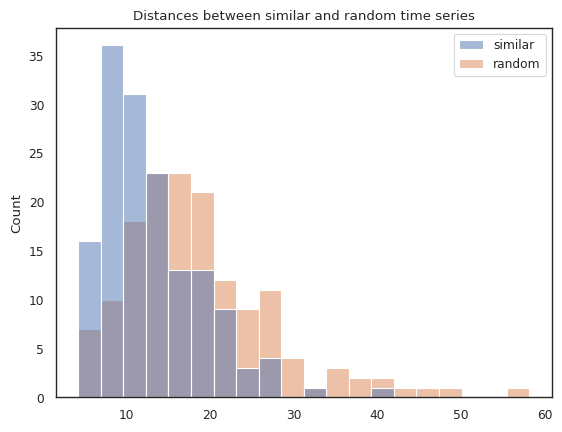

In [17]:
ts_type = 'sentiment_ts'

ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
for column in ts_data.columns:
    ts_data[column] = list(
        map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]

x = sim_dtw+rnd_dtw
h = (['similar'] * len(sim_dtw)) + (['random'] * len(rnd_dtw))

fig, ax = plt.subplots()
ax = sns.histplot(x=x, hue=h)
ax.set_title('Distances between similar and random time series')

tikzplotlib.save('../tikz/hist_eval_sentiment.tex')

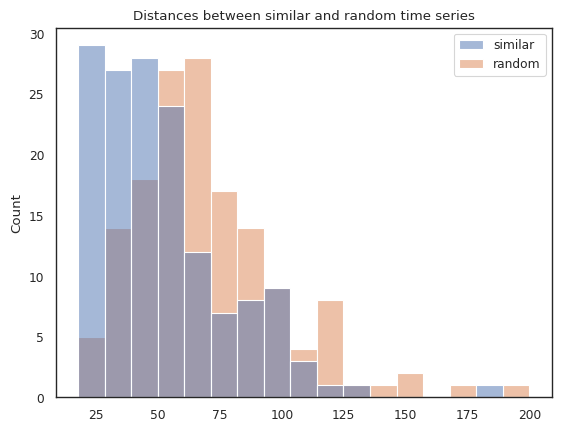

In [18]:
ts_type = 'emotion_ts'

ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
for column in ts_data.columns:
    ts_data[column] = list(
        map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]

x = sim_dtw+rnd_dtw
h = (['similar'] * len(sim_dtw)) + (['random'] * len(rnd_dtw))

fig, ax = plt.subplots()
ax = sns.histplot(x=x, hue=h)
ax.set_title('Distances between similar and random time series')

tikzplotlib.save('../tikz/hist_eval_emotion.tex')